# Import Important Packages

In [1]:
import os
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import color, io,transform,feature,exposure,img_as_ubyte,filters,measure
from sklearn.feature_extraction.image import PatchExtractor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score


# Image Feature Extraction Function (Histogram)

In [2]:
# Function to extract histogram features from an image
def extract_histogram_features(image, bins=5):
    hsv_image = color.rgb2hsv(image)
    hist_hue = exposure.histogram(hsv_image[:, :, 0], nbins=bins)[0]
    hist_saturation = exposure.histogram(hsv_image[:, :, 1], nbins=bins)[0]
    hist_value = exposure.histogram(hsv_image[:, :, 2], nbins=bins)[0]
    hist_combined = np.concatenate((hist_hue, hist_saturation,hist_value ))
    hist_combined = hist_combined.astype("float")
    hist_combined /= (hist_combined.sum() + 1e-7)
    return hist_combined

# List all subdirectories (Apply Feature Extraction on Each Image)

In [3]:
dataset_path = "leafs"

# List all subdirectories (assuming each subdirectory corresponds to a class)
class_folders = [f.path for f in os.scandir(dataset_path) if f.is_dir()]
features = []
labels = []

# Loop through each class folder
for class_idx, class_folder in enumerate(class_folders):
    class_name = os.path.basename(class_folder)

    # Loop through each image in the class folder
    for inx, image_filename in enumerate(os.listdir(class_folder)):
        image_path = os.path.join(class_folder, image_filename)

        # Load the image
        image = io.imread(image_path)
        hist_features = extract_histogram_features(image,8)

        features.append(hist_features)
        labels.append(class_idx)


# Shuffle Features

In [4]:
# # Combine pathes and images into pairs
# combined_data = list(zip(features, img_name))

# # Shuffle the combined data
# random.shuffle(combined_data)

# # Unpack the shuffled data and labels
# features, img_name = zip(*combined_data)

# Convert the list of Features to a 2D array and Starndarize it

In [5]:
# Convert the list of images to a 2D array (assuming images have the same size)
features_data = np.array((features)).reshape(len(features), -1)

# Standardize the image data
scaler = StandardScaler()
features_data_standardized = scaler.fit_transform(features_data)

# Apply PCA

In [6]:
# Apply PCA
num_components = 10  # Adjust the number of components based on your requirements
pca = PCA(n_components=num_components)
image_data_pca = pca.fit_transform(features_data_standardized)

# Apply PCA

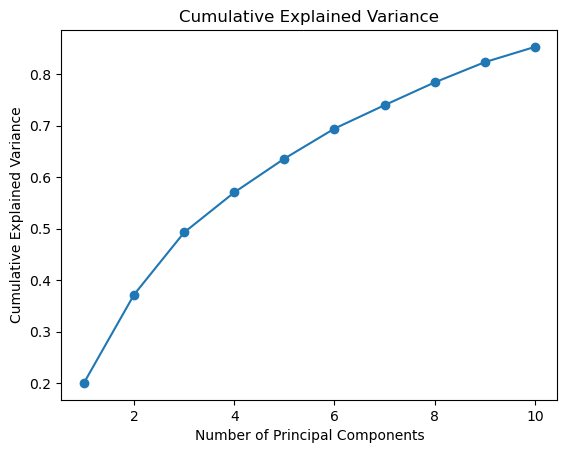

In [7]:
# Visualize the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.plot(range(1, num_components + 1), cumulative_explained_variance, marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# K_folds

In [8]:
# Perform k-fold cross-validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Initialize silhouette_scores & accuracy_scores

In [9]:
silhouette_scores = []
accuracy_scores = []

# plotting the elbow graph

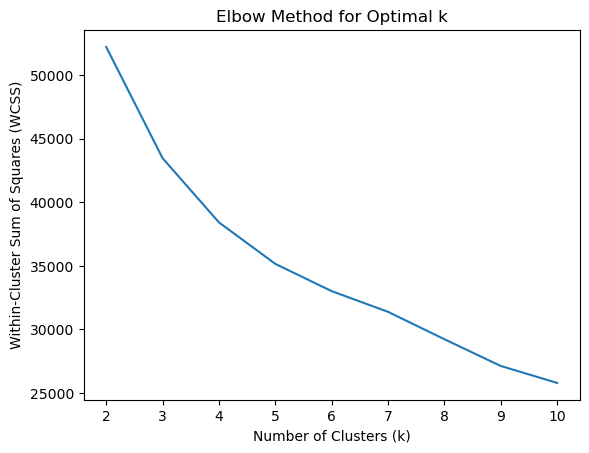

In [10]:
# For plotting the elbow graph
wcss = []

for k in range(2, 11):  # Try different values of k
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(image_data_pca)
    wcss.append(kmeans.inertia_)

plt.plot(range(2, 11), wcss)
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.show()

# Calculate Average Silhouette Score, Average Accuracy & plot Clusters with Centroid

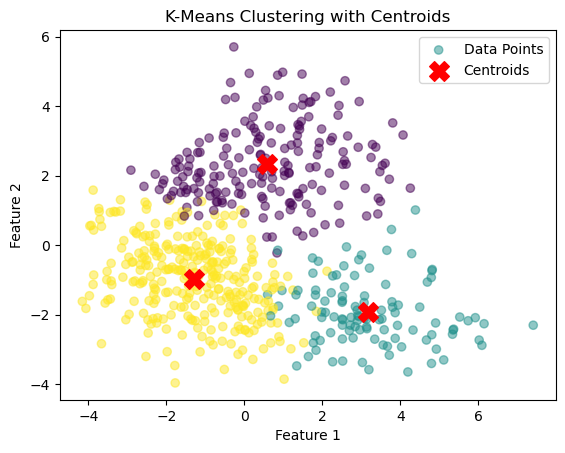

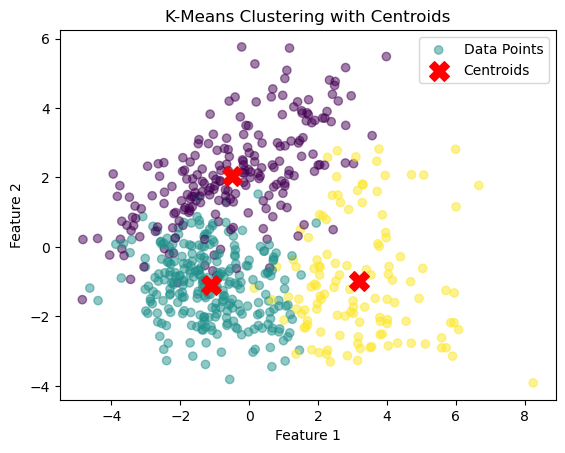

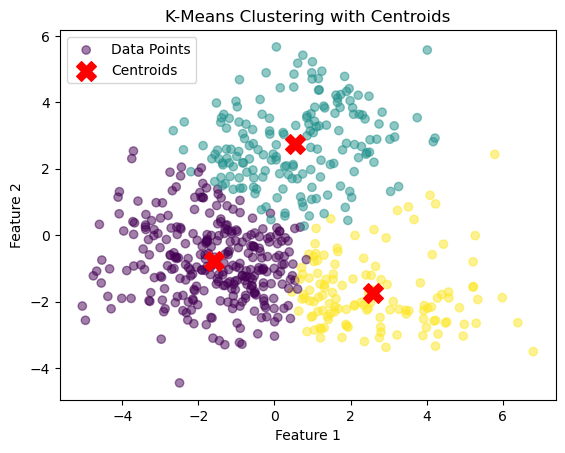

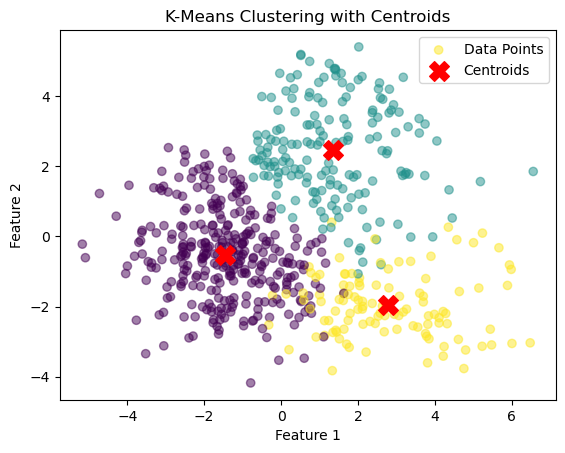

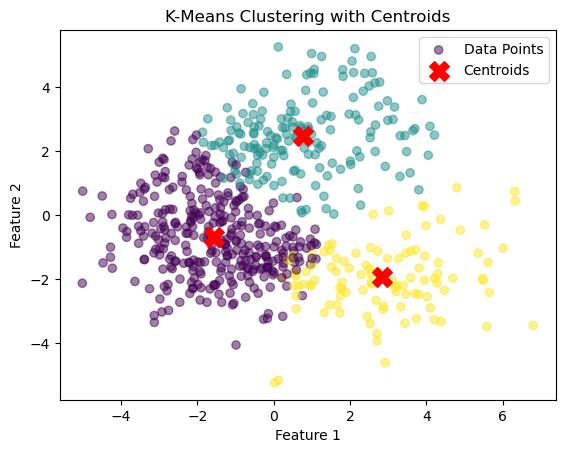

Average Silhouette Score across 5 folds: 0.20515721526477454
Average Accuracy Score across 5 folds: 0.7180506399554814


In [11]:
# accuracy and score and ploting                features_data_standardized

for train_index, test_index in kf.split(image_data_pca):
    X_train, X_test = image_data_pca[train_index], image_data_pca[test_index]
    y_train, y_test = np.array(labels)[train_index], np.array(labels)[test_index]

    # You may need to choose an appropriate number of clusters (n_clusters) for your specific case
    kmeans = KMeans(n_clusters=len(class_folders), random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(X_test)
    
    # Plotting the data points
    plt.scatter(X_test[:, 0], X_test[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5, label='Data Points')

    # Plotting the centroids
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Centroids')

    plt.title('K-Means Clustering with Centroids')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

    # Assign class labels to clusters based on the majority class
    centroid_labels = []
    for cluster in range(len(class_folders)):
        cluster_points = np.where(cluster_labels == cluster)[0]
        majority_label = np.bincount(y_test[cluster_points]).argmax()
        centroid_labels.append(majority_label)

    # Assign class labels to the entire test set
    y_pred = np.array([centroid_labels[cluster] for cluster in cluster_labels])

    # Step 5: Compute silhouette score for the current fold
    silhouette_avg = silhouette_score(X_test, cluster_labels)
    silhouette_scores.append(silhouette_avg)

    # Step 6: Compute accuracy score for the current fold
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

# Step 7: Average silhouette scores and accuracy scores over all folds
average_silhouette_score = np.mean(silhouette_scores)
average_accuracy_score = np.mean(accuracy_scores)

print(f"Average Silhouette Score across {k_folds} folds: {average_silhouette_score}")
print(f"Average Accuracy Score across {k_folds} folds: {average_accuracy_score}")





    